# Deep Learning and Neural Networks with PyTorch

<p align="center">
  <img src="notebook_images/ImageNet.jpg", height="500", width="500" />
</p>

Above, you see some images from ImageNet. ImageNet is a large dataset of over 14 million labeled images in 20000 different categories. Each year, the ImageNet Large Scale Visual Recognition Challenge is held where participants try to classify the images in ImageNet to the categories they belong to. In 2011 the number 1 entry achieved a top 5 error rate (number of times the correct classification is in the top 5 guesses) of 25%. The following year, in 2012, the number 1 entry called AlexNet scored **16%**, leaving that year's number 2 entry far behind.

<p align="center">
  <img src="notebook_images/ImageNetResults.png", height="500", width="409" />
</p>

How did the score in this competition improve so massively in only one year? Given the title of this workshop it should come as no surprise that AlexNet was a neural network, more specifically a deep learning model. Nowadays, deep learning models are widely used in all sorts of areas, and they are especially successful in most computer vision and natural language processing tasks.

## What is a neural network?

Let's start with the basics. Neural networks are a specific type of machine learning model loosely based on the idea of the neurons in our brain (hence the name). A neural network consists of layers of nodes. You could think of each node as a cell that stores a number. This number is also called the node's activation.

Layers of nodes are connected. Specifically, in a feedforward neural network, each node has incoming connections from the previous layer and outgoing connections to the next layer. Connections between nodes have values, known as weights. These weights are multiplied with the activation in a node in one layer to determine the activation in a receiving node in the next layer. The input a node gets from a node in a preceding layer can be as simple as:

<p align="center">
<b> weight $\times$ activation of previous node </b>
</p>

By connecting layers of nodes into a final layer of a desired output format, we can build machine learning models capable of many tasks. All we have to do is figure out what the weights should be so that an input pattern results in our desired output.

<p align="center">
  <img src="notebook_images/NeuralNetwork.gif" />
</p>

To take a less abstract look at the concept, let's consider the example above. Here's a graphical representation of how a neural network works. In the example, an image of the number seven is converted into a vector of activation values. Each element of the vector represents the light intensity in a single pixel of that image. This vector forms the input for the first layer of nodes in our network. The input is then passed through the layers of nodes, where we can see the connections between the nodes lighting up as yellow lines. By having trained the network, the weights of the connections have gotten the right values so that the nodes in the input layer eventually excite the right node in the output layer. Note that the output layer consists of 10 nodes, one node for each possible digit.

## Deep learning
Now that we understand what a neural network is, let's talk about deep learning. Deep learning really is no more than using neural networks with many layers. Historically, deep learning models were very computationally intensive to train. In recent years, the use of graphical processing units (GPUs) has massively accelerated the efficiency with which these models can be trained. GPUs are processors normally used for video processing within a computer, but their capability to rapidly perform many calculations in parallel can also be leveraged to train deep learning models.

<p align="center">
  <img src="notebook_images/Features.png" />
</p>

One way to look at the advantage of deep learning is by considering what research has shown from dissecting deep learning image classifiers. In these models, the nodes in the first few layers of the network tend to be reactive to very small, low-level features of the image, like lines and edges. However, the nodes in later layers are reactive to progressively complex features. Thus, by using many layers in succession, we can extract increasingly complex feature to, hopefully, improve the performance of the model.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchinfo import summary

from helper_functions import plot_images, plot_images_predictions, plot_train_val_loss, plot_batch

## Welcome to PyTorch

Time to get hands-on and start building a neural network ourselves. [PyTorch](https://pytorch.org/) is an open-source deep learning framework available in Python. Today, we will be using it to build our own image classifier.

Let's start with the basics: PyTorch uses its own version of a NumPy array, called a [tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), to store data.

In [2]:
tensor = torch.tensor([[1, 2],[3, 4]])
tensor

tensor([[1, 2],
        [3, 4]])

### The value of tensors

As we can see above, a tensor is just like a NumPy array. However, a tensor has two advantages over standard NumPy arrays:

* First, a tensor can run on a GPU, unlike a NumPy array.
* Second, tensors have been optimalized for automatic differentiation. We'll get back to the importance of this in a little bit, but automatic differentiation plays an important role in training neural networks.

In [3]:
# If we'd like to pass a tensor to a gpu, here's how we'd do it:
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

print(f'Tensor is currently running on: {tensor.device}')

Tensor is currently running on: cpu


Tensors will form the input to the neural network we will be building. In this case, we would like to build a classifier in which we classify from which of seven countries an image of a mailbox is. The countries we'll be using are Germany, Spain, France, Ireland, Japan, the Netherlands, the United Kingdom, and the United States.

In [4]:
classes = ["DE", "ES", "FR", "IE", "JP", "NL", "UK", "US"]

## Dataset

To build our classifier, we will need some data in the form of images of mailboxes from different countries. The dataset has already been provided for us. The folder data/train contains the images of mailboxes we will use for our train set, while data/test contains the images we will use for our validation set.

Let's try and load an image from each class to see what these mailboxes look like.

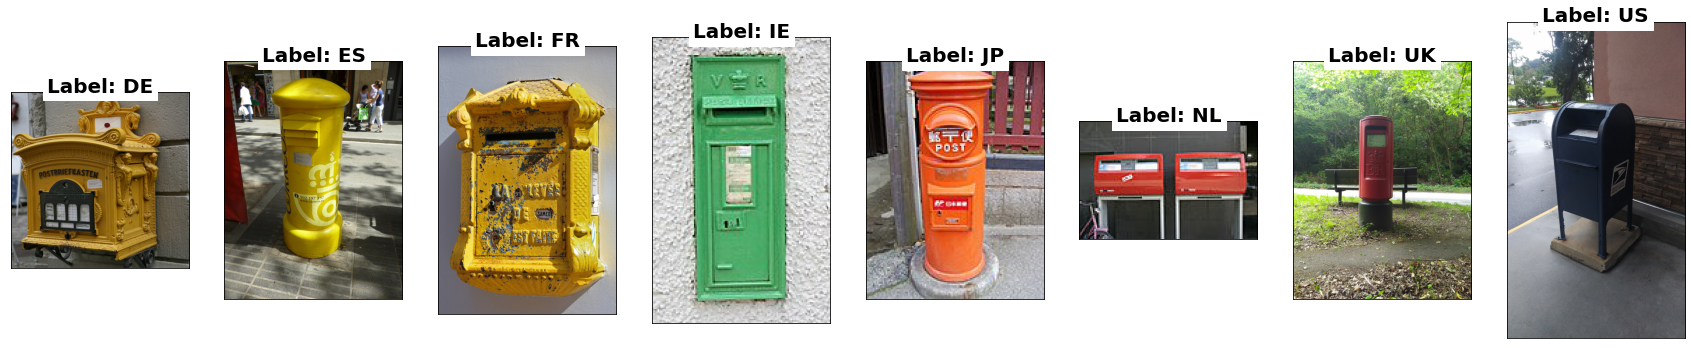

In [5]:
plot_images('data/train', classes)

Now that we have some image data to work with, we'll need to instantiate our dataset. PyTorch offers the functionality to build your own [custom datasets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), which offers us the ability to iterate through any data we could load as a tensor.

Luckily for us, PyTorch also readily implements [many options for image datasets](https://pytorch.org/vision/stable/datasets.html). In this case, we will be using the [ImageFolder class](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder), which allows us to create a dataset from a folder, with the names of the labels as subfolders.

## Explain relation image <-> Tensor

One thing that becomes apparent from the plot above, is that all images are not of the same dimensions yet. Because neural networks have a fixed number of nodes per layer, fixing the size of the images like this tends to be an important step in pre-processing our data. For this reason, we'll resize the images to a fixed size of 64 by 64 pixels.

In [6]:
base_transformations = [
    # Resize images to 64 by 64 pixels
    transforms.Resize((64,64)),
    # Transform  images into tensors
    transforms.ToTensor(),
]

We could also apply [augmentations](https://pytorch.org/vision/stable/transforms.html). Augmentations are image transformations aimed at expanding our dataset. For instance, below, we randomly rotate an image between 45 and -45 degrees. Uncomment the line in the augmentation_transformations list and run the next few cells to see what kind of images this yields.

In [7]:
augmentation_transformations = [
    # transforms.RandomRotation(degrees=(-45, 45))
]

train_transformations = transforms.Compose(base_transformations + augmentation_transformations)
test_transformations = transforms.Compose(base_transformations)

train_set = ImageFolder("data/train", transform=train_transformations)
val_set = ImageFolder("data/test", transform=test_transformations)

To iterate through our dataset, we'll need PyTorch's [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which will create an iterator capable of loading the mailbox images in batches in a random order. Let's create two, one for our train and one for our validation set.

We will also need to pass the batch size of our data loader, which will determine how many images are loaded per iteration. You might wonder why we do not just pass the full dataset at once. There are two reasons for this. First, neural networks tend to train faster when passing the data in batches. Second, it requires less memory when training the network. In the case of large, raw files like images this is especially helpful if we are not able to fit the full dataset at once in memory.

There is lots of discussion regarding the ideal batch size to use, and it is very much a parameter you can tune while building a neural network. For this use case, we will use a batch size of 32, which convention states is a good starting point.

In [8]:
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

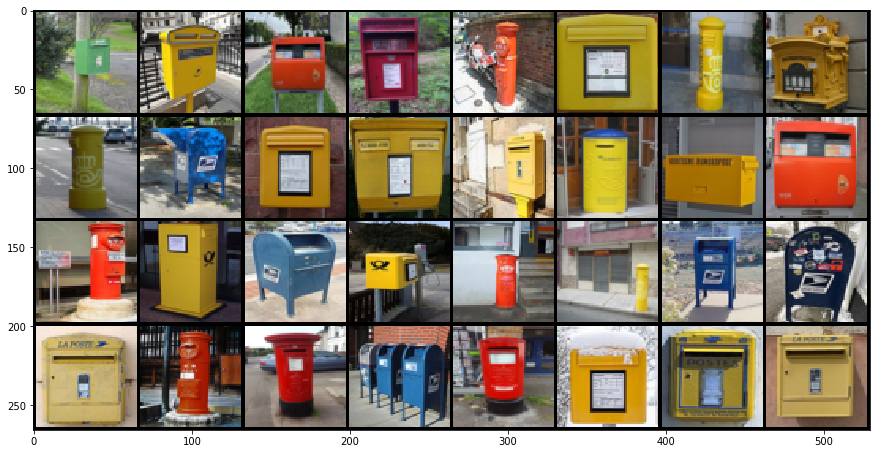

In [9]:
# Plot one batch of images
w = next(iter(train_dataloader))[0]
grid = make_grid(w, nrow=8)
plot_batch(grid)

We should now be able to iterate through our dataset and load images in batches.

In [10]:
for x, y in train_dataloader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 64, 64])
tensor([1, 0, 0, 2, 5, 2, 2, 7, 7, 0, 7, 6, 2, 6, 6, 4, 4, 2, 1, 6, 7, 0, 2, 1,
        3, 2, 4, 1, 4, 0, 2, 6])


# **Building the model**

In [11]:
# Get device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Now that we have a way to load in our data and pass it to our neural network in batches, we can start actually building the network. This is done by creating a new class, which inherits from PyTorch's [nn.Module class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Subsequently, we will need to actually build the layers of our neural network. We can use the building blocks from the [torch.nn module](https://pytorch.org/docs/stable/nn.html). This module contains layers we can use in our neural network. In the class we have created for our neural network, we can then define the layers we want to use in \_\_init\_\_.

Below, we have built a model consisting of [nn.Linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), also known as fully connected layers. These are layers where each node in the layer has a connection to each node in the succeeding layer. Each fully connected layer is separated by a [nn.ReLU layer](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). This layer is also known as an activation function and serves to modify the activation provided by the preceding linear layer. Specifically, a ReLU layer sets all inputs below 0 to 0 and leaves the rest of the inputs as is. The main reason to use such an activation function is to introduce non-linearities into the network.

You'll also notice an [nn.Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html). Because our fully connected layers will not be able to handle multi-dimensional tensors, like the three channels in our tensor representing the RGB values of the image, the flatten function will convert our input to a 1-dimensional tensor. While there are ways to deal with this more elegantly, these methods are beyond the scope of today's workshop.

We've wrapped some layers with [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to chain our layers together. This container allows us to chain together any number of layers that we would like to use in sequence.

The last piece of the puzzle is the forward() method. This will define through which layers the samples we pass to our network will go.

In [12]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # The input to the first layer matches the size of 1 image
            nn.Linear(3*64*64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        # The output of the last layer matches the number of classes
        self.last_layer = nn.Sequential(
            nn.Linear(64, len(classes))
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.last_layer(x)
        return x

model = NeuralNetwork().to(device)

We can use the `summary()` function from torchinfo to see how the model behaves. It will show us the layers of the model, the shape of the output tensor from a layer, and the number of tunable parameters per layer.

In [13]:
summary(model, (batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            --                        --
├─Flatten: 1-1                           [32, 12288]               --
├─Sequential: 1-2                        [32, 64]                  --
│    └─Linear: 2-1                       [32, 64]                  786,496
│    └─ReLU: 2-2                         [32, 64]                  --
│    └─Linear: 2-3                       [32, 64]                  4,160
│    └─ReLU: 2-4                         [32, 64]                  --
├─Sequential: 1-3                        [32, 8]                   --
│    └─Linear: 2-5                       [32, 8]                   520
Total params: 791,176
Trainable params: 791,176
Non-trainable params: 0
Total mult-adds (M): 25.32
Input size (MB): 1.57
Forward/backward pass size (MB): 0.03
Params size (MB): 3.16
Estimated Total Size (MB): 4.77

# **Training the model**

We have now defined a model: all that is left to do is train it.

To train our model, we will need a couple of things. First, we'll need a loss function, which will quantify the dissimilarity between the output from our neural network and our target. For classification problems like the one at our hands here, a common choice for a loss function is [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

Once we know this quantity for a batch of samples, also known as the loss, we will need to update the model parameters to gradually bring it down. In a neural network, this is done via backpropagation. The exact technical details of this algorithm are not important for now. The basic idea is that backpropagation computes the gradient of the weights with respect to the loss function. If we know the gradient of these weights with regard to the loss function, we should also have a general idea of how to update our weights in order to bring our loss down.

<p align="center">
  <img src="notebook_images/GD.gif", width="700", height="397" />
</p>

In our case PyTorch will do the heavy lifting of for us via an optimization algorithm. Here we use [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Pytorch implements such optimization algorithms in the [torch.optim](https://pytorch.org/docs/stable/optim.html) module. We'll also set a learning rate. This will determine how large the updates to the weights are. The larger the learning rate, the more they will change. If the learning rate is too large, we will not be able to find the global minimum as the weights will change too much on each update to settle on one minimum. But, if the learning rate is too small, we will not be able to get out of local minima. Thus, the learning rate has a large impact on training the network as well.

In [14]:
loss_fn = nn.CrossEntropyLoss()

# By passing model.parameters() we'll tell the optimization algorithm which parameters to optimize
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

We'll create a function for our training loop. The training loop really consists of a few steps:

1. Create predictions for a single batch of images and calculate loss.
2. Set previously calculated gradients to zero
3. Backpropagate the loss through the layers of the network to calculate gradients
4. Update the weights



In [15]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)

    # Set the model to train mode
    model.train()
    running_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Push X and y tensors to relevant device (CPU or GPU)
        X, y = X.to(device), y.to(device)

        # 1. Create predictions for a single batch of images and calculate loss.
        pred = model(X)
        loss = loss_fn(pred, y)

        # 2. Set previously calculated gradients to zero
        optimizer.zero_grad()

        # 3. Backpropagate the loss through the layers of the network to calculate gradients
        loss.backward()

        # 4. Update the weights
        optimizer.step()

        running_loss += loss.item()

        # if (batch + 2) * len(X) > size:
    avg_loss = running_loss / num_batches
    return avg_loss

We'll also create a function for testing on our validation data. Here, we do not want to execute the backpropagation algorithm, as that would mean we would be optimizing our model on validation data. Thus, we leave out a couple of steps in this function.

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Set the model to eval mode
    model.eval()
    running_loss, correct = 0, 0

    # Disable backpropagation
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Generate predictions
            preds = model(X)

            # Calculate loss and number of correct predictions
            running_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = running_loss / num_batches
    correct /= size

    return correct * 100, avg_loss

We'll log the progress of training in epochs. An epoch is when all the data in our dataset has passed the training loop for one iteration.

In [20]:
epochs = 50
best_score = 0.

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_correct, val_loss = test(val_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch+1} | Train loss: {train_loss:>5f} | Test loss: {val_loss:>5f} | Correctly classified: {val_correct:>0.1f}%')
        best_score = max(best_score, val_correct)


print(f'Best score: {best_score:>0.1f}%')

Epoch: 1 | Train loss: 1.851578 | Test loss: 1.835517 | Correctly classified: 27.3%


KeyboardInterrupt: 

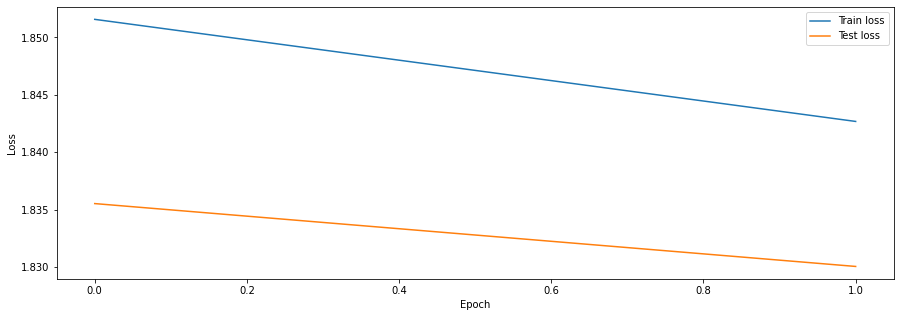

In [21]:
plot_train_val_loss(train_losses, val_losses)

## Now it's your turn!

Now that we know how to build a neural network, it is your time to shine! Your goal is to create as accurate of a classifier as possible. Below you'll find all the code needed to build your own neural network. You're given 50 epochs to train your model, and your final score will be measured on the validation set after these 50 epochs.

We'll give you some tips to get started on building your own model, in the order you will encounter them:

* **Augmentation:** Data preparation is a very important step when building neural networks. You can add augmentation to artificiallly create more variety in your dataset. We've already shown you one method of augmentation, [transforms.RandomRotation](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html). You can check [here](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) for more augmentation methods. As we only want augmentation in our training data, you should make sure not to apply these same methods to your validation set.
* **Number of layers:** You can change the number of layers in the model to be able to capture more complex relations. However, be aware that adding extra layers also increases the probability of overfitting, as more layers means the network is able to represent more complex patterns. As such, if you feel like you are overfitting, you could also decrease the number of layers instead.
* **Number of nodes:** Each layer also has a number of nodes it consists of. Similar to the number of layers, you could also add increase or decrease the number of nodes in a layer. More nodes means more capacity of the network to model more complex relationships. However,  as with the number of layers, too many nodes means risking overfitting.
* **Activation functions:** While we have exclusively used [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) so far, there are many more activation functions to introduce non-linearities into the network. You can find them [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). Some popular alternative choices to ReLU include: [nn.ELU](https://pytorch.org/docs/stable/generated/torch.nn.ELU.html#torch.nn.ELU), [nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU), [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid), and [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh). For instance, if we'd want to use the Sigmoid activation function instead of ReLU, we'd simply put `nn.Sigmoid()` instead of `nn.ReLU()`.
* **Dropout:** Another way to regularize neural networks is by applying dropout layers. The idea here is to randomly set some elements of the input to 0, so that the model can, for example, not become dependent on a value of a single neuron for determining its output. In practice, we'd introduce a dropout layer with a probability of .2 as follows: `nn.Dropout(p=0.2)`
* **Weight decay:** Another way to regularize neural networks is by applying weight decay. Weight decay applies an L2 penalty to the weights, shrinking them over time. This is done by adding a `weight_decay` parameter in the call to the optimization function. For stochastic gradient descent, we could, for instance, do:
`torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)`

* **Learning rate:** The learning rate determines how large the updates to the weights are. If the learning rate is too large, the weights will update too much to converge on a minimum (and the loss will jump around). However, if the learning rate is too small, we will not be able to get out of local minima and training will be slow. Thus, tweaking the learning rate `lr` parameter in the call to `torch.optim.SGD()` can be important to train our model.

* **Optimization algorithm:** In this case we use [optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), or the stochastic gradient descent optimization algorithm, but there are many other options you might try out. For instance, other popular choices are [optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) or [optim.Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

In [22]:
# We will need this bit of code to transform our images into tensors
base_transformations = [
    transforms.Resize((64,64)),
    transforms.ToTensor(),
]

augmentation_transformations = [
    transforms.RandomRotation(degrees=(-45, 45))
]

train_transformations = transforms.Compose(base_transformations + augmentation_transformations)
test_transformations = transforms.Compose(base_transformations)

train_set = ImageFolder("data/train", transform=train_transformations)
val_set = ImageFolder("data/test", transform=test_transformations)

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# Plot batch
w = next(iter(train_dataloader))[0]
grid = make_grid(w, nrow=8)
plot_batch(grid)

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # The input to the first layer matches the size of 1 image
            nn.Linear(3*64*64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        # The output of the last layer matches the number of classes
        self.last_layer = nn.Sequential(
            nn.Linear(64, 8)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.last_layer(x)
        return x

model = NeuralNetwork().to(device)


In [ ]:
summary(model, (batch_size, 3, 64, 64))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Use this code to reset all parameters in the model
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

epochs = 50
best_score = 0.

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_correct, val_loss = test(val_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch+1} | Train loss: {train_loss:>5f} | Test loss: {val_loss:>5f} | Correctly classified: {val_correct:>0.1f}%')
        best_score = max(best_score, val_correct)

print(f'Best score: {best_score:>0.1f}%')

In [ ]:
plot_train_val_loss(train_losses, val_losses)

In [ ]:
plot_images_predictions(model=model,
                        classes=classes,
                        dataset=val_set)